---
---
---
<a name="COMPILE"></a>
## C) Make `torch.compile` work without graph breaks for QLoRA [Difficulty: Easy to Medium] [Max points: 9]

1. Goal: Write a single Python script like task B), except the goal is to `torch.compile` all modules if possible.

2. There must NOT be graph breaks, and excessive re-compilations should not be seen.

3. You should have say max 30 compilations. Over 60 is definitely wrong.

4. The loss must match with the non compiled module.

5. Utilize patching as much as possible.

6. Think about which areas might need disabling for compilation. Think about regional compilation. How do we compile sections efficiently?

7. Log memory / VRAM usage, and monitor speedups as well.

8. Must work for QLoRA.

We provided a script below, and showcased how to detect if graph breaks are seen. We also torch compiled the MLP for Llama:

### Marking Criteria for C) Max points = 9
```python
if attemped_C:
    C_score = 0
    if uses_flex_attention:
        if dynamic_sequence_length_works: C_score += 3
        else: C_score += 1
    if no_torch_compile_BnB: C_score -= 2
    elif use_part_A: C_score += 1
    elif torch_compile_BnB: C_score += 1

    if attention_compiled:
        if excessive_recompilation: C_score -= 3
        else: C_score += 2
    if mlp_compiled:
        if excessive_recompilation: C_score -= 3
        C_score += 1

    if not loss_compiled: C_score -= 1
    if not layernorms_compiled: C_score -= 3

    if max_autotune_triton_matmul:
        if excessive_recompilation: C_score -= 2
        else: C_score += 2
    
    final_score += C_score
else:
    final_score -= 1
```

In [22]:
# Code to install Unsloth, Triton, Torch etc
# %%capture
# !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
# !pip install --no-deps cut_cross_entropy unsloth_zoo
# !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
# !pip install --no-deps unsloth

In [23]:
# Helpful functions used through the entire notebook
import torch
import torch.nn as nn
from transformers import set_seed
import time
import inspect
import os

major_version, minor_version = torch.cuda.get_device_capability()
HAS_BFLOAT16 = major_version >= 8
from inspect import currentframe as _C, getframeinfo

_F = lambda c: getframeinfo(c).lineno  # Gets line number
WARN = lambda x: print(f"\033[31m{x}\033[0m")  # Red colored warnings


# https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
def NAME(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = [var_name for var_name, var_val in callers_local_vars if var_val is var]
    return names[0] if len(names) != 0 else ""


def assert_same(x, y, line, dtype):
    assert x.dtype == dtype
    try:
        torch.testing.assert_close(x, y, check_stride=True)
    except Exception as error:
        raise RuntimeError(
            f"Failed allclose at line [{line}]: {NAME(x)}, {NAME(y)}\n{str(error)}"
        )


os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [24]:
torch_compile_options = {
    "epilogue_fusion": True,
    "max_autotune": True,
    "shape_padding": True,
    "trace.enabled": True,
    "triton.cudagraphs": False,
}

TOGGLE_ORIGINAL = True


@torch.compile(fullgraph=False, dynamic=True, options=torch_compile_options)
def compiled_llama_mlp(self, x):
    down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
    return down_proj

import transformers.models.llama.modeling_llama

transformers.models.llama.modeling_llama.LlamaMLP.forward = compiled_llama_mlp

In [25]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = (
    "expandable_segments:True," "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"
)

max_seq_length = 1024
torch.set_default_dtype(torch.float16)
model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"
dtype = torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    attn_implementation="sdpa",
    quantization_config=bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_dropout=0,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name:
            param.requires_grad_(True)
        else:
            param.requires_grad_(False)

# Currently GC will cause torch.compile to be disabled, so disable it
# model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# Get dataset
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig

url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files={"train": url}, split="train[:10%]")

/opt/conda/lib/python3.12/site-packages/transformers/quantizers/auto.py:206: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Now that the model has been loaded, we inspect, and then patch and compile parts of the model.

In [26]:
# Must show all graph breaks are not seen with torch.compile
import os

os.environ["TORCHDYNAMO_VERBOSE"] = "1"
os.environ["TORCHINDUCTOR_FORCE_DISABLE_CACHES"] = "1"
os.environ["TORCHINDUCTOR_COMPILE_THREADS"] = "1"

import logging

torch._inductor.config.debug = True
torch._logging.set_logs(
    dynamo=logging.WARN,
    inductor=logging.WARN,
    graph_breaks=True,
    recompiles=True,
    recompiles_verbose=True,
    compiled_autograd_verbose=True,
    # aot_joint_graph = True, # Enable for more logs
    # aot_graphs = True,
)
torch._dynamo.config.verbose = True
torch._dynamo.config.suppress_errors = False

In [27]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    processing_class=tokenizer,
    args=SFTConfig(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=2,
        warmup_steps=1,
        max_steps=10,
        logging_steps=1,
        output_dir="outputs",
        seed=3407,
        max_seq_length=max_seq_length,
        fp16=model.get_input_embeddings().weight.dtype == torch.float16,
        bf16=model.get_input_embeddings().weight.dtype == torch.bfloat16,
        report_to="none",  # For W&B
        dataset_num_proc=4,
    ),
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
V0320 23:58:40.533000 21755 site-packages/torch/_dynamo/symbolic_convert.py:617] [37/0] [__graph_breaks] Graph break: from user code at:
V0320 23:58:40.533000 21755 site-packages/torch/_dynamo/symbolic_convert.py:617] [37/0] [__graph_breaks]   File "/tmp/ipykernel_21755/2678255783.py", line 14, in compiled_llama_mlp
V0320 23:58:40.533000 21755 site-packages/torch/_dynamo/symbolic_convert.py:617] [37/0] [__graph_breaks]     down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
V0320 23:58:40.533000 21755 site-packages/torch/_dynamo/symbolic_convert.py:617] [37/0] [__graph_breaks]   File "/opt/conda/lib/python3.12/site-packages/peft/tuners/lora/bnb.py", line 496, in forward
V0320 23:58:40.533000 21755 site-packa

TrainOutput(global_step=10, training_loss=2.385467863082886, metrics={'train_runtime': 8.7518, 'train_samples_per_second': 2.285, 'train_steps_per_second': 1.143, 'total_flos': 10592155496448.0, 'train_loss': 2.385467863082886})

In [28]:
train_history = trainer.state.log_history
original_losses = []
original_steps = []

for log in train_history:
    if "loss" in log:
        original_losses.append(log["loss"])
        original_steps.append(log["step"])
original_losses

[1.5196, 2.3939, 2.5033, 3.534, 2.1388, 2.9796, 2.2489, 1.6291, 2.2208, 2.6867]

In [29]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = (
    "expandable_segments:True," "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"
)

max_seq_length = 1024
torch.set_default_dtype(torch.float16)
model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"
dtype = torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    attn_implementation="sdpa",
    quantization_config=bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_dropout=0,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name:
            param.requires_grad_(True)
        else:
            param.requires_grad_(False)

# Currently GC will cause torch.compile to be disabled, so disable it
# model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# Get dataset
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig

url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files={"train": url}, split="train[:10%]")

/opt/conda/lib/python3.12/site-packages/transformers/quantizers/auto.py:206: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


In [30]:
for name, module in model.named_modules():
    print("\n")
    print(name, type(module))
    
    for attr_name in dir(module):
        # Avoid special/private attributes and methods
        if attr_name.startswith('_'):
            continue

        try:
            attr_value = getattr(module, attr_name)

            # Print the attribute name and value (or its type, if it's complex)
            print(f"  {attr_name}: ", end="")
            if isinstance(attr_value, (int, float, str, bool)):
                print(attr_value)
            elif isinstance(attr_value, torch.Tensor):
                print(f"Tensor with shape {attr_value.shape}, dtype {attr_value.dtype}, device {attr_value.device}")
            elif isinstance(attr_value, nn.Module):
                print(f"nn.Module of type {type(attr_value)}")
            else:
                print(f"of type {type(attr_value)}")  # Print the type for complex objects
        except Exception as e:
            print(f"(Error getting attribute: {e})")




 <class 'peft.peft_model.PeftModelForCausalLM'>
  T_destination: of type <class 'typing.TypeVar'>
  active_adapter: default
  active_adapters: of type <class 'list'>
  active_peft_config: of type <class 'peft.tuners.lora.config.LoraConfig'>
  add_adapter: of type <class 'method'>
  add_module: of type <class 'method'>
  apply: of type <class 'method'>
  base_model: nn.Module of type <class 'peft.tuners.lora.model.LoraModel'>
  base_model_prepare_inputs_for_generation: of type <class 'method'>
  base_model_torch_dtype: of type <class 'torch.dtype'>
  bfloat16: of type <class 'method'>
  buffers: of type <class 'method'>
  call_super_init: False
  children: of type <class 'method'>
  compile: of type <class 'method'>
  cpu: of type <class 'method'>
  create_or_update_model_card: of type <class 'method'>
  cuda: of type <class 'method'>
  disable_adapter: of type <class 'method'>
  double: of type <class 'method'>
  dump_patches: False
  eval: of type <class 'method'>
  extra_repr: of t

In [31]:
model.base_model.model.model.layers

ModuleList(
  (0-15): 16 x LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): lora.Linear4bit(
        (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
        (lora_dropout): ModuleDict(
          (default): Identity()
        )
        (lora_A): ModuleDict(
          (default): Linear(in_features=2048, out_features=32, bias=False)
        )
        (lora_B): ModuleDict(
          (default): Linear(in_features=32, out_features=2048, bias=False)
        )
        (lora_embedding_A): ParameterDict()
        (lora_embedding_B): ParameterDict()
        (lora_magnitude_vector): ModuleDict()
      )
      (k_proj): lora.Linear4bit(
        (base_layer): Linear4bit(in_features=2048, out_features=512, bias=False)
        (lora_dropout): ModuleDict(
          (default): Identity()
        )
        (lora_A): ModuleDict(
          (default): Linear(in_features=2048, out_features=32, bias=False)
        )
        (lora_B): ModuleDict(
          (default)

We grab our dequantization kernel from A, which we'll need to fix the biggest issue: the Linear4bit hidden layers. It is torch compilable with some minor modifications to the params:
- avoid the triton cdiv
- ensure that tl.constexpr are treated as constants

In [32]:
import triton 
import triton.language as tl

@triton.jit
def dequantize_nf4_code(code_index):
    """Helper function to dequantize a 4-bit NF4 code to its float value."""
    bit3 = (code_index & 0x8) != 0  # Check if bit 3 is set (8)
    bit2 = (code_index & 0x4) != 0  # Check if bit 2 is set (4)
    bit1 = (code_index & 0x2) != 0  # Check if bit 1 is set (2)
    bit0 = (code_index & 0x1) != 0  # Check if bit 0 is set (1)

    # we avoid reading the code values directly, as they are not contiguous.
    return tl.where(bit3,
        # 1xxx
        tl.where(bit2,
            # 11xx
            tl.where(bit1,
                # 111x
                tl.where(bit0, 1.0, 0.7229568362236023),
                # 110x
                tl.where(bit0, 0.5626170039176941, 0.44070982933044434)
            ),
            # 10xx
            tl.where(bit1,
                # 101x
                tl.where(bit0, 0.33791524171829224, 0.24611230194568634),
                # 100x
                tl.where(bit0, 0.16093020141124725, 0.07958029955625534)
            )
        ),
        # 0xxx
        tl.where(bit2,
            # 01xx
            tl.where(bit1,
                # 011x
                tl.where(bit0, 0.0, -0.09105003625154495),
                # 010x
                tl.where(bit0, -0.18477343022823334, -0.28444138169288635)
            ),
            # 00xx
            tl.where(bit1,
                # 001x
                tl.where(bit0, -0.39491748809814453, -0.5250730514526367),
                # 000x
                tl.where(bit0, -0.6961928009986877, -1.0)
            )
        )
    )

@triton.autotune(
    configs=[
        # may need further configuration based on hardware
        triton.Config({'BLOCK_SIZE': 32}),
        triton.Config({'BLOCK_SIZE': 64}),
        triton.Config({'BLOCK_SIZE': 128}),
        triton.Config({'BLOCK_SIZE': 256}),
        triton.Config({'BLOCK_SIZE': 512}),
        triton.Config({'BLOCK_SIZE': 1024}),
    ],
    key=['total_elements'],
)
@triton.jit()
def _your_dequantize_nf4_kernel(
    weight_ptr,  # [uint8]  Quantized weights, 1 byte => 2 NF4 elements
    absmax_ptr,  # [int]  One int "index" per element
    absmax2_ptr,  # [float]  One absmax2 per block
    # code_ptr,  # [float]  NF4 code lookup
    code2_ptr,  # [float]  Absmax code lookup
    offset_ptr,  # [float]  Offset to add after absmax is decoded
    out_ptr,  # [float]  Final dequantized output
    weight_blocksize: tl.constexpr,  # [int]   Number of elements in a weight block
    absmax_blocksize: tl.constexpr, # [int]   Number of elements in a absmax block
    total_elements,  # [int]   Number of actual float elements to reconstruct
    BLOCK_SIZE: tl.constexpr,
):
    # context; we adopt the pov of a quantized byte, which corresponds to 2 elems
    pid = tl.program_id(0)
    index = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)

    offset = tl.load(offset_ptr, eviction_policy="evict_last")

    # weight_block_index = index // (weight_blocksize // 2) # the block index of the byte
    # now we end up with a vector like (0, 0, ... 0, 0, 1, 1, ...)
    # we can shrink this by applying a stride of weight_blocksize // 2
    weight_block_index = pid * BLOCK_SIZE // (weight_blocksize // 2) + tl.arange(0, BLOCK_SIZE // (weight_blocksize // 2))

    absmax_block_index = weight_block_index // absmax_blocksize # the block index of the absmax

    # mask calculations
    byte_index_mask = index < (total_elements // 2)
    weight_block_mask = weight_block_index < (total_elements // weight_blocksize) 
    abs_block_mask = absmax_block_index < (total_elements // weight_blocksize // absmax_blocksize)

    # compute absmax for the block these weights belong to:
    absmax1_code = tl.load(absmax_ptr + weight_block_index, mask=weight_block_mask, eviction_policy="evict_first")
    absmax1_code = absmax1_code.to(tl.int16) # this is necessary
    
    # reading values from code is likely a very slow process due to lack of contiguity
    absmax1_val = tl.load(code2_ptr + absmax1_code, mask=(absmax1_code < 256), cache_modifier=".ca")
    absmax2_val = tl.load(absmax2_ptr + absmax_block_index, mask=abs_block_mask, eviction_policy="evict_first")
    
    absmax = tl.fma(absmax1_val, absmax2_val, offset)

    # lookup each weight bit
    byte = tl.load(weight_ptr + index, mask=byte_index_mask, eviction_policy="evict_first").to(tl.uint8)

    # matter of covention which set of bits is the first and second
    code_index2 = byte & 0x0F  # Lower 4 bits
    code_index1 = (byte >> 4) & 0x0F  # Upper 4 bits

    # Dequantize both 4-bit values
    weight1 = dequantize_nf4_code(code_index1)[:, None].reshape(BLOCK_SIZE // (weight_blocksize // 2), (weight_blocksize // 2)) * absmax[:, None]
    weight1 = tl.ravel(weight1)
    weight2 = dequantize_nf4_code(code_index2)[:, None].reshape(BLOCK_SIZE // (weight_blocksize // 2), (weight_blocksize // 2)) * absmax[:, None]
    weight2 = tl.ravel(weight2)
    
    tl.store(out_ptr + (index * 2), weight1, mask=byte_index_mask, cache_modifier=".cs")
    tl.store(out_ptr + (index * 2 + 1), weight2, mask=byte_index_mask, cache_modifier=".cs")

    tl.debug_barrier()

NF4_WEIGHT_BLOCKSIZE = 64
NF4_ABSMAX_BLOCKSIZE= 256

def triton_dequantize_nf4(weight, quant_state):
    absmax = quant_state.absmax
    shape = quant_state.shape
    dtype = quant_state.dtype
    blocksize = quant_state.blocksize
    offset = quant_state.offset
    state2 = quant_state.state2
    absmax2 = state2.absmax
    code2 = state2.code
    blocksize2 = state2.blocksize

    # TL_BLOCKSIZE = 128 # can't be too large

    out = torch.empty(shape, dtype=dtype, device="cuda")
    # cdiv: (x + y - 1) // y
    # weight_grid = ((out.numel() // 2 + TL_BLOCKSIZE -1) // TL_BLOCKSIZE, )
    weight_grid = lambda meta: ((out.numel() // 2 + meta["BLOCK_SIZE"] -1) // meta["BLOCK_SIZE"], )

    # if blocksize != NF4_WEIGHT_BLOCKSIZE:
    #     raise ValueError(f"Blocksize must be {NF4_WEIGHT_BLOCKSIZE}, got {blocksize}")
    # if blocksize2 != NF4_ABSMAX_BLOCKSIZE:
    #     raise ValueError(f"Blocksize2 must be {NF4_ABSMAX_BLOCKSIZE}, got {blocksize2}")

    _your_dequantize_nf4_kernel[weight_grid](
        weight,
        absmax,
        absmax2,
        code2,
        offset,
        out,
        # these need to be constants for the purpose of 
        weight_blocksize=NF4_WEIGHT_BLOCKSIZE,
        absmax_blocksize=NF4_ABSMAX_BLOCKSIZE,
        total_elements=out.numel(),
        # BLOCK_SIZE=TL_BLOCKSIZE,
    )
    return out

In [33]:
class Linear4bitCompilable(nn.Module):
    def __init__(self, bnb_linear):
        super().__init__()
        # Copy over quantized weight and metadata from the bitsandbytes layer
        self.in_features = bnb_linear.in_features
        self.out_features = bnb_linear.out_features
        self.quant_type = bnb_linear.weight.quant_type
        self.blocksize = bnb_linear.weight.blocksize
        self.weight = bnb_linear.weight.data  # don't trace param 4 bit, access its vars here
        self.quant_state = bnb_linear.weight.quant_state
        self.bias = bnb_linear.bias
        
        # Freeze weight and metadata as buffers (no grad needed)
        self.weight.requires_grad_(False)

    @torch.compile(fullgraph=True, dynamic=True, options=torch_compile_options)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Use the triton kernel for dequantization
        if self.quant_type == "nf4":
            # Dequantize the weights using the triton kernel
            W = triton_dequantize_nf4(self.weight, self.quant_state)
        else:
            # For other quantization types (like fp4), we would need a different implementation
            raise NotImplementedError(f"Quantization type {self.quant_type} not supported yet")
            
        # Compute linear output: x @ W^T + bias
        out = torch.matmul(x, W.t())
        if self.bias is not None:
            out = out + self.bias.to(x.dtype)
        return out


In [ ]:
from typing import Optional, Tuple
from transformers.integrations.sdpa_attention import repeat_kv

def patched_sdpa_attention_forward(
    module: torch.nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    dropout: float = 0.0,
    scaling: Optional[float] = None,
    is_causal: Optional[bool] = None,
    **kwargs,
) -> Tuple[torch.Tensor, None]:

    # stole sdpa implementation from source
    if hasattr(module, "num_key_value_groups"):
        key = repeat_kv(key, module.num_key_value_groups)
        value = repeat_kv(value, module.num_key_value_groups)

    causal_mask = attention_mask
    if attention_mask is not None:
        causal_mask = causal_mask[:, :, :, : key.shape[-2]]

    query = query.contiguous()
    key = key.contiguous()
    value = value.contiguous()

    # we can just set is_casual to true since we're training
    attn_output = torch.nn.functional.scaled_dot_product_attention(
        query,
        key,
        value,
        attn_mask=causal_mask,
        dropout_p=dropout,
        scale=scaling,
        is_causal=True,
    )
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, None


In [35]:
# compilable llama attention
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb

def patched_llama_attention_forward(
    self,
    hidden_states: torch.Tensor,
    position_embeddings: Tuple[torch.Tensor, torch.Tensor],
    attention_mask: Optional[torch.Tensor],
    past_key_value = None,
    cache_position: Optional[torch.LongTensor] = None,
    **kwargs,
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    input_shape = hidden_states.shape[:-1]
    hidden_shape = (*input_shape, -1, self.head_dim)

    query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
    key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
    value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

    cos, sin = position_embeddings
    query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

    if past_key_value is not None:
        # sin and cos are specific to RoPE models; cache_position needed for the static cache
        cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
        key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

    attn_output, attn_weights = patched_sdpa_attention_forward(
        self,
        query_states,
        key_states,
        value_states,
        attention_mask,
        dropout=0.0 if not self.training else self.attention_dropout,
        scaling=self.scaling,
        **kwargs,
    )

    attn_output = attn_output.reshape(*input_shape, -1).contiguous()
    attn_output = self.o_proj(attn_output)
    return attn_output, attn_weights


import transformers.models.llama.modeling_llama
transformers.models.llama.modeling_llama.LlamaAttention.forward = patched_llama_attention_forward

In [36]:
modules_to_replace = []
for name, module in model.named_modules():
    module_type = str(type(module))
    # leave out the lora modules
    if "lora" in module_type.lower():
        continue
    if "bnb" in module_type or "bitsandbytes" in module_type:
        # print(name, type(module))
        modules_to_replace.append(name)

# patch modules
for name in modules_to_replace:
    module = model.get_submodule(name)
    # create a new patched module from the old one
    new_module = Linear4bitCompilable(module)
    # Find the direct parent module
    parts = name.split('.')
    parent = model
    for i in range(len(parts) - 1):
        parent = parent.get_submodule(parts[i])

    module_name = parts[-1] # The attribute name within the parent
    setattr(parent, module_name, new_module)


In [37]:
# compile the model's modules
module_names = set()
for index, child in model.base_model.model.model.layers.named_children():
    for name, module in child.named_children():
        # compile the layernorm, self-attention, and mlp modules (already compiled)
        if any(k in name for k in ["layernorm", "self_attn", "mlp"]):
            # Add dynamic shape assumptions
            module = torch.compile(module, fullgraph=False, dynamic=True, options=torch_compile_options)
            setattr(child, name, module)
        
        module_names.add(name)
        
print(module_names)

{'self_attn', 'mlp', 'post_attention_layernorm', 'input_layernorm'}


In [38]:
# then also compile the loss function:
loss_function = model.loss_function

@torch.compile(fullgraph=False, dynamic=True, options=torch_compile_options)
def compiled_loss_function(self, **kwargs):
    return loss_function(**kwargs)

model.loss_function = compiled_loss_function

In [39]:
# Finally, to avoid recompilations of the attention module due to a `len(L['past_key_value'].key_cache) == N` guard failures
# we need to ensure the cache used is static.
# We can do this by pre-defining past_key_values for the model in forward
# from transformers.cache_utils import StaticCache
# from transformers.models.llama.modeling_llama import LlamaModel

# forward_function = LlamaModel.forward

# def patched_forward(self, *args, **kwargs):
#     past_key_values = StaticCache(
#         config=self.config,
#         max_batch_size=1, # match train config
#         device=self.device,
#         dtype=self.dtype,
#     )
#     input_ids = args[0] if len(args) > 0 else None

#     inputs = dict(kwargs)  # copy so we can safely modify

#     if input_ids is not None and "input_ids" not in inputs:
#         inputs["input_ids"] = input_ids

#     if "past_key_values" not in inputs or inputs["past_key_values"] is None:
#         inputs["past_key_values"] = past_key_values

#     return forward_function(self, **inputs)

# import transformers.models.llama.modeling_llama
# transformers.models.llama.modeling_llama.LlamaModel.forward = patched_forward



# opting out of patching this since using the static cache uses a lot more memory
# and there's still more to be done to prevent recompiles.
# the number of recompiles is already currently acceptable

In [40]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    processing_class=tokenizer,
    args=SFTConfig(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=2,
        warmup_steps=1,
        max_steps=10,
        logging_steps=1,
        output_dir="outputs",
        seed=3407,
        max_seq_length=max_seq_length,
        fp16=model.get_input_embeddings().weight.dtype == torch.float16,
        bf16=model.get_input_embeddings().weight.dtype == torch.bfloat16,
        report_to="none",  # For W&B
        dataset_num_proc=4,
    ),
)

trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
W0320 23:59:04.982000 21755 site-packages/torch/_inductor/debug.py:434] [41/0] model__29_forward_70 debug trace: /workspaces/unsloth-ai-feb2025/torch_compile_debug/run_2025_03_20_23_36_22_437010-pid_21755/torchinductor/model__29_forward_70.49
W0320 23:59:06.560000 21755 site-packages/torch/_inductor/debug.py:434] [41/0] model__29_backward_71 debug trace: /workspaces/unsloth-ai-feb2025/torch_compile_debug/run_2025_03_20_23_36_22_437010-pid_21755/torchinductor/model__29_backward_71.50
W0320 23:59:11.223000 21755 site-packages/torch/_inductor/debug.py:434] [35/1] model__30_forward_73 debug trace: /workspaces/unsloth-ai-feb2025/torch_compile_debug/run_2025_03_20_23_36_22_437010-pid_21755/torchinductor/model__30_forward_73.51
W0320 23:59

TrainOutput(global_step=10, training_loss=2.3843496561050417, metrics={'train_runtime': 127.3817, 'train_samples_per_second': 0.157, 'train_steps_per_second': 0.079, 'total_flos': 240546115584.0, 'train_loss': 2.3843496561050417})

In [41]:
train_history = trainer.state.log_history
patched_losses = []
patched_steps = []

for log in train_history:
    if "loss" in log:
        patched_losses.append(log["loss"])
        patched_steps.append(log["step"])
patched_losses

[1.5192, 2.3924, 2.4978, 3.5328, 2.1374, 2.9782, 2.2491, 1.629, 2.2216, 2.6859]

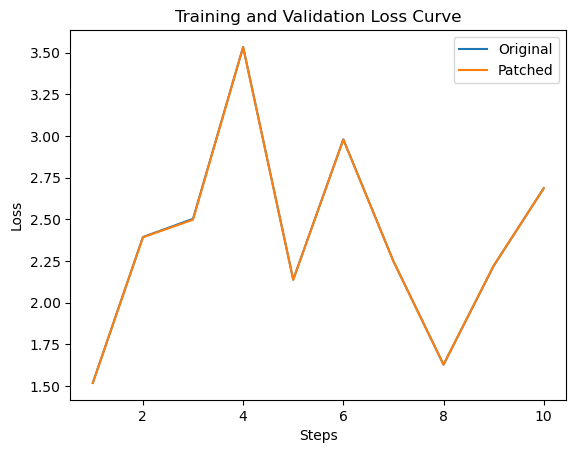

In [42]:
import matplotlib.pyplot as plt

plt.plot(original_steps, original_losses, label="Original")
plt.plot(patched_steps, patched_losses, label="Patched")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()  # Show the legend
plt.show()

We have the same loss curve, 9 recompiles after compiling the loss, norms, attention, and mlp and with autotune.